# **NLP Insights on Medicare Dataset**

This notebook presents an in-depth analysis of **Medicare tweets** leveraging a range of Natural Language Processing (NLP) techniques. Initial steps involved comprehensive preprocessing to ensure the data's readiness for analysis. This included handling null values, eliminating duplicates, removing digits, storwords, twitter handles (@), punctuations, unnecessary texts, URLs, and common words from the dataset.

The analysis incorporates the following NLP techniques:

- N-gram (Bi-gram, Tri-gram)
- Tweet stats (bag-of-words, TF-IDF)
- Sentiment Analysis (sentiment over time)
- Topic Modelling
- Sarcasm Detection
- BERT Sentiment Analysis


**Installing required libraries.**

Install pyLDAvis library for interactive topic visualization dashboard.

In [2]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.4 MB/s eta 0:00:00


Load libraries.

In [3]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models

## Load data

Load the dataset

In [5]:
df = pd.read_csv('medicare.csv')
df_original= pd.read_csv('medicare.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# display the column names of the datasets
df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['id', 'created_at', 'date', 'time', 'username', 'name', 'tweet',
       'language', 'hashtags'],
      dtype='object')

As the first step, we can select a subset of columns required for our analysis. This can be done based on your business requirement.


In [ ]:
# selecting only the columns that are necessary
df=df[['date','time','tweet']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,time,tweet
0,2022-04-10,12:03:03,@luisanibalmend2 @barbraguinsky @LaRubiaOk Era...
1,2022-04-10,04:40:33,The #telehealth ads are STILL on the radio aft...
2,2022-04-09,06:00:49,Will more bureaucracy in #NSWHealth improve #N...
3,2022-04-08,23:56:21,I don't like the sound of the American Health ...
4,2022-04-08,00:22:35,Just had a family member come up against this ...


## Preprocessing

Preprocessing applies to the dataset.

Now we run the preprocessing.

In [6]:
# Transform sentences into lowercase
df['tweet'] = df['tweet'].str.lower()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Following command is just to visualize the processed dataframe
df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,time,tweet
38107,2022-04-05,22:25:37,"then for the love of god, recant your hypothet..."
38108,2022-04-05,22:25:35,if only there was a house bill for that called...
38109,2022-04-05,22:25:29,"@berniesanders also..., medicare for all and t..."
38110,2022-04-05,22:25:27,it’s time to make “medicare for all” a part of...
38111,NaN,NaN,NaN


Remove twitter user ids that are mentioned in the tweet text. We will use [regular expressions ](https://www.w3schools.com/python/python_regex.asp) to do this.  
In applying the regular expression, we use the string in the format r"regular-expression". This is to treat the regex as a raw string. Additional information on this can be found from [this stackoverflow question](https://stackoverflow.com/questions/4780088/what-does-preceding-a-string-literal-with-r-mean).

In [7]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['tweet'] = df['tweet'].apply(remove_twitter_ids)
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,created_at,date,time,username,name,tweet,language,hashtags
0,1513125404063645698,2022-04-10 12:03:03+00:00,2022-04-10,12:03:03,estebanlaplata,Luislaplata,era un boludou espaa tiene salud pblica ingla...,es,[]
1,1513014045082746883,2022-04-10 04:40:33+00:00,2022-04-10,04:40:33,muzzpol,Muzzpol,the telehealth ads are still on the radio afte...,en,"['telehealth', 'auspol', 'ausvotes', 'medicare..."
2,1512671857803104257,2022-04-09 06:00:49+00:00,2022-04-09,06:00:49,muzzpol,Muzzpol,will more bureaucracy in nswhealth improve nsw...,en,"['nswhealth', 'nsw', 'rural', 'tweedvalleyhosp..."
3,1512580134314049536,2022-04-08 23:56:21+00:00,2022-04-08,23:56:21,pnslipper,Peter Slipper,i dont like the sound of the american health s...,en,"['medicare', 'auspol']"
4,1512224349561925634,2022-04-08 00:22:35+00:00,2022-04-08,00:22:35,aparachick,aparachick,just had a family member come up against this ...,en,[]


### Duplicate removal

It is essential we check for duplicates. Because, the tweets are extracted from Twitter API and it is likely the same tweet repeats multiple times.  
We can utilize pandas drop_duplicates() function. [Link to API](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DataFrame.drop_duplicates.html)

In [8]:
# Check duplicate tweets count
duplicate_count = len(df['tweet'])-len(df['tweet'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])



duplicate count: 12325
total records before remove duplicates: 42017


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# drop duplicates (keep the last tweet of each of the duplicates)
df = df.drop_duplicates(subset='tweet', keep="first")
print('updated record count:', df.shape[0])

updated record count: 29692


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we will remove all punctuation, retaining just the text.




In [10]:
# Remove punctuations
df['tweet'] = df['tweet'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,created_at,date,time,username,name,tweet,language,hashtags
42011,1511144416672509954,2022-04-05 00:51:19+00:00,2022-04-05,00:51:19,eric_t_roberts,Eric T. Roberts,we found that incomplete dental coverage in th...,en,['medicare']
42012,1511144354986881025,2022-04-05 00:51:04+00:00,2022-04-05,00:51:04,carbon_truth,CarbonCountyTruth,gops new plan would raise taxes on working peo...,en,"['raisetaxes', 'gop', 'medicare', 'socialsecur..."
42013,1511144339455492100,2022-04-05 00:51:00+00:00,2022-04-05,00:51:00,theroguex,Travis Hughes,seriously limiting costsharing in insurance pl...,en,[]
42014,1511144222522417152,2022-04-05 00:50:33+00:00,2022-04-05,00:50:33,eric_t_roberts,Eric T. Roberts,our study examined a cliff in dental coverage ...,en,"['medicaid', 'medicare']"
42016,1511143902761275392,2022-04-05 00:49:16+00:00,2022-04-05,00:49:16,kweriousgeorge,billo 🇺🇦,remind me how many transgender athletes we r ...,en,"['fascistgop', 'ga']"


### Stop words and domain related word removal

Now let's conduct further text pre- processing using NLTK library. First, remove stopwords.

In [11]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note that the term 'not' is in the stop word list. This will have a negative impact on sentiment analysis. However, if the NLP technique is topic modeling,  there will be no such impact. It is important to keep this mind, drop or retain words depending on the goal of your exercise.  
For this case, we will remove the term 'not' from the stopword list.

In [14]:
stop.remove('not')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

df['tweet'] = df['tweet'].apply(remove_stop_words)
df.tail(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,created_at,date,time,username,name,tweet,language,hashtags
42011,1511144416672509954,2022-04-05 00:51:19+00:00,2022-04-05,00:51:19,eric_t_roberts,Eric T. Roberts,found incomplete dental coverage medicare prog...,en,['medicare']
42012,1511144354986881025,2022-04-05 00:51:04+00:00,2022-04-05,00:51:04,carbon_truth,CarbonCountyTruth,gops new plan would raise taxes working people...,en,"['raisetaxes', 'gop', 'medicare', 'socialsecur..."
42013,1511144339455492100,2022-04-05 00:51:00+00:00,2022-04-05,00:51:00,theroguex,Travis Hughes,seriously limiting costsharing insurance plans...,en,[]
42014,1511144222522417152,2022-04-05 00:50:33+00:00,2022-04-05,00:50:33,eric_t_roberts,Eric T. Roberts,study examined cliff dental coverage via medic...,en,"['medicaid', 'medicare']"
42016,1511143902761275392,2022-04-05 00:49:16+00:00,2022-04-05,00:49:16,kweriousgeorge,billo 🇺🇦,remind many transgender athletes r talking lot...,en,"['fascistgop', 'ga']"


### Standardization of tweets - Stemming

We shall use stemming to standardize tweets.  
[Stemming](https://en.wikipedia.org/wiki/Stemming) is the removal of prefix, suffix etc, to derive the base form of a word. We will use the NLTK library.

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['tweet_stemmed'] = df['tweet'].apply(stemming_function)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Compare the content vs. stemmed content
df[['tweet', 'tweet_stemmed']].head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet,tweet_stemmed
0,era un boludou espaa tiene salud pblica inglat...,era un bolud espaa tien salud pblica inglaterr...
1,telehealth ads still radio auspol election cal...,telehealth ad still radio auspol elect call st...
2,bureaucracy nswhealth improve nsw rural health...,bureaucraci nswhealth improv nsw rural health ...
3,dont like sound american health system protect...,dont like sound american health system protect...
4,family member come issue today must changed au...,famili member come issu today must chang austr...
5,claire yes govt determine rate services lets c...,clair ye govt determin rate servic let call bu...
6,albo supported pliberseks disgusting 2019 ausv...,albo support plibersek disgust 2019 ausvot pol...
7,late news sydneythere new auspol govt taxpayer...,late news sydneyther new auspol govt taxpay fu...
8,hasnt many countries medicare australia,hasnt mani countri medicar australia
9,answers auspol qt say genetic screening funded...,answer auspol qt say genet screen fund budget2...


The stemming has turned term 'government' to 'govern', thus, stemming has not deemed expected results in this context.  Thereby, we will go ahead with original content without any standardization.   
You may attempt to lemmatize and see if you can improve the results.

# Standardization of tweets - Lemmatization

Lemmatization reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

We will use Wordnet for the lemmatization. Thus, we need to download Wordnet to the nltk library.

WordNet is a lexical database for the English language. It groups English words into sets of synonyms called synsets, provides short definitions and usage

In [17]:
# Download wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

lemmtizer = WordNetLemmatizer()

def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_sentence = " ".join(lemma_word_list)
  return lemma_sentence

df['tweet_lemmatized'] = df['tweet'].apply(lemmatize_function)

df[['tweet', 'tweet_lemmatized']].head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,tweet,tweet_lemmatized
0,era un boludou espaa tiene salud pblica inglat...,era un boludou espaa tiene salud pblica inglat...
1,telehealth ads still radio auspol election cal...,telehealth ad still radio auspol election call...
2,bureaucracy nswhealth improve nsw rural health...,bureaucracy nswhealth improve nsw rural health...
3,dont like sound american health system protect...,dont like sound american health system protect...
4,family member come issue today must changed au...,family member come issue today must changed au...
5,claire yes govt determine rate services lets c...,claire yes govt determine rate service let cal...
6,albo supported pliberseks disgusting 2019 ausv...,albo supported pliberseks disgusting 2019 ausv...
7,late news sydneythere new auspol govt taxpayer...,late news sydneythere new auspol govt taxpayer...
8,hasnt many countries medicare australia,hasnt many country medicare australia
9,answers auspol qt say genetic screening funded...,answer auspol qt say genetic screening funded ...


## Word frequency analysis

Let us look at the most occuring words and the least occuring words in our tweet dataset.

In [ ]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['tweet']).split()).value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Look at the top 10 words
word_frequency[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


medicare    26990
rebate       9189
not          4564
amp          3597
health       3453
get          2951
care         2654
social       2587
security     2382
people       2194
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


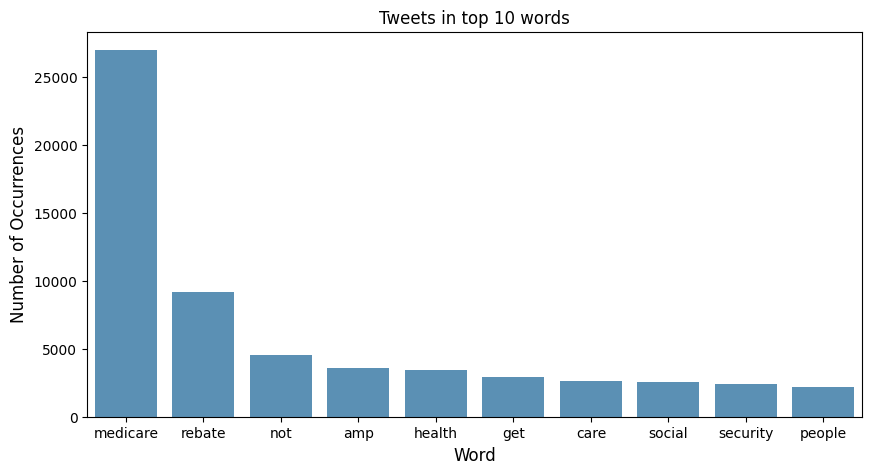

In [ ]:
# Visualize the top word counts

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(x=word_count.index, y=word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

Insights-
From the above bar graph and the corresponding table, we can see that medicare and rebate are the most frequently used words in the tweets.

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

In [ ]:
from PIL import Image
from wordcloud import WordCloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


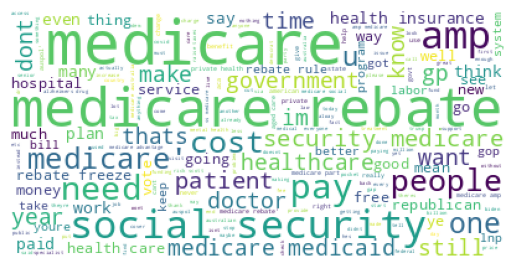

In [ ]:
corpus = list(df['tweet'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Insight**  
From the word cloud we could identify that terms medicare, thats and amp have been mentioned frequently. But this is expected but does not provide so much an insight. Therefore, we are going to remove high frequent yet non-insightful words alongside the twitter specific words.

### Remove common words

Let's  remove context specific words and the most common words from the tweets.

The tweets extracted are from the hashtags @medicare, these keywords will appear in most tweets. Let's  add those keywords to the set of words to be removed.  
We can extend the new_words list with those additional keywords, which we think will be widely used due to the area/domain the tweets were extracted.

In [ ]:
# Creating a list of custom stopwords
new_words_to_remove = ["amp","medicare","thats"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Remove common words
# We will use lambda function here.
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,time,tweet,tweet_stemmed,tweet_lemmatized
0,2022-04-10,12:03:03,era un boludou espaa tiene salud pblica inglat...,era un bolud espaa tien salud pblica inglaterr...,era un boludou espaa tiene salud pblica inglat...
1,2022-04-10,04:40:33,telehealth ads still radio auspol election cal...,telehealth ad still radio auspol elect call st...,telehealth ad still radio auspol election call...
2,2022-04-09,06:00:49,bureaucracy nswhealth improve nsw rural health...,bureaucraci nswhealth improv nsw rural health ...,bureaucracy nswhealth improve nsw rural health...
3,2022-04-08,23:56:21,dont like sound american health system protect...,dont like sound american health system protect...,dont like sound american health system protect...
4,2022-04-08,00:22:35,family member come issue today must changed au...,famili member come issu today must chang austr...,family member come issue today must changed au...


We will re-attempt to compose a frequency appearing word list since we have removed the non insightful words.

In [ ]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['tweet']).split()).value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Look at the top 10 words (you can write either word_frequency[:10] or word_frequency[0:10]. Both give the same result.)
word_frequency[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rebate       9189
not          4564
health       3453
get          2951
care         2654
social       2587
security     2382
people       2194
pay          2169
insurance    2104
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


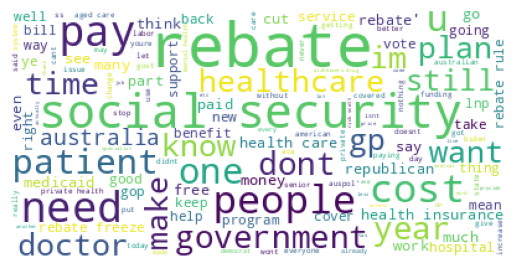

In [ ]:
corpus = list(df['tweet'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## n-Grams - Bigrams and Trigrams

The following commands will extract bigrams from the tweet dataset.  


### Bigrams

We will use CountVectorizer object from sklearn to generate bi-grams and tri-grams. [Link to API](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  


In [ ]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):

    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0)

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bigrams = get_ngrams(df['tweet'].tolist(), ngram_range=(2, 2))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bigrams

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('social security', 2296),
 ('health insurance', 755),
 ('health care', 640),
 ('rebate freeze', 593),
 ('rebate rule', 506),
 ('private health', 470),
 ('aged care', 440),
 ('alzheimers drug', 368),
 ('get rebate', 363),
 ('mental health', 346),
 ('raise taxes', 284),
 ('rick scott', 250),
 ('private insurance', 233),
 ('security medicaid', 231),
 ('climate change', 214),
 ('bulk billing', 211),
 ('take away', 210),
 ('middle class', 209),
 ('cant afford', 204),
 ('drug prices', 200),
 ('insurance companies', 190),
 ('clinical trials', 186),
 ('drug rebate', 182),
 ('bulk bill', 181),
 ('end social', 180),
 ('tax rebate', 171),
 ('new alzheimers', 170),
 ('get rid', 163),
 ('rebate not', 155),
 ('indue card', 155),
 ('public health', 147),
 ('insurance tax', 146),
 ('tax seniors', 145),
 ('2018 health', 142),
 ('dont want', 141),
 ('im not', 140),
 ('stop 2018', 140),
 ('universal healthcare', 138),
 ('dont know', 138),
 ('prescription drug', 138),
 ('student debt', 138),
 ('seniors 

Convert bigrams of the dataset to a dataframe with column names bi-gram and frequency.

In [ ]:
bigrams_df = pd.DataFrame(bigrams)
bigrams_df.columns=["Bi-gram", "Freq"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-36-27491bd9a6cd>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels


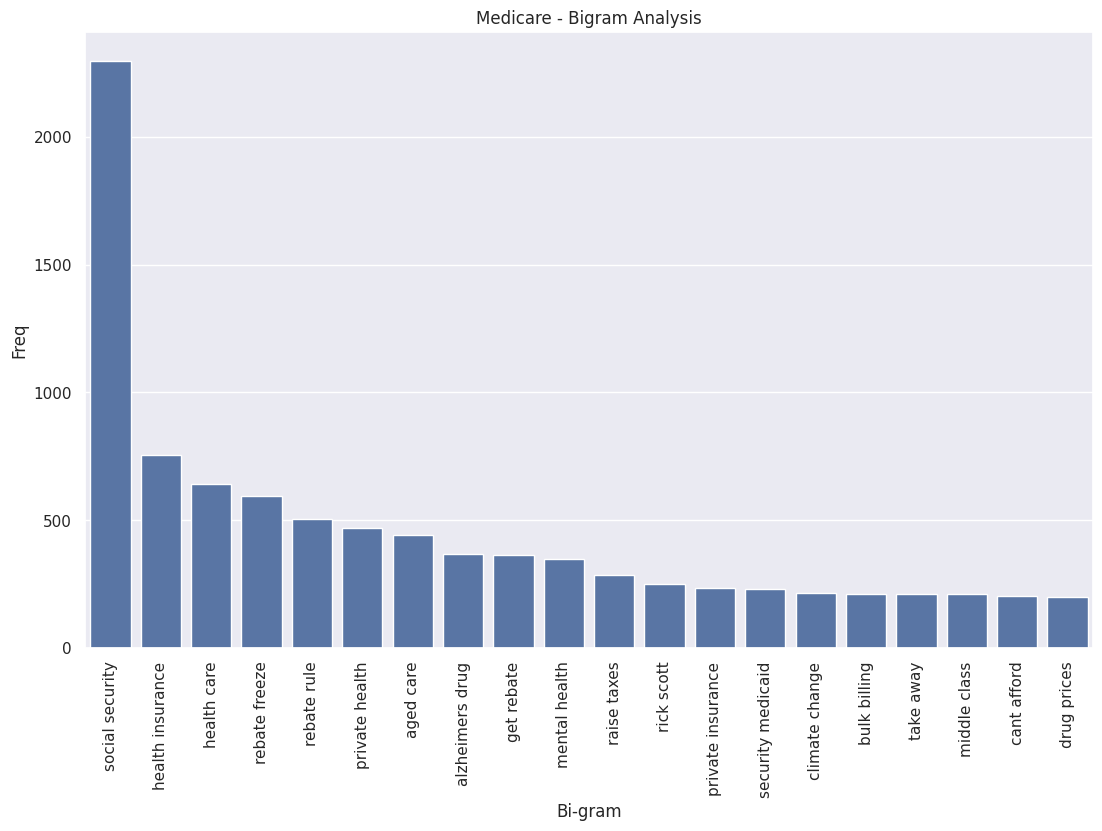

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Medicare - Bigram Analysis')
plt.show()

**Insights**:  

The bigram "social security" likely denotes the interconnection between Medicare and Social Security, as Medicare eligibility often aligns with eligibility for Social Security benefits. Similarly, phrases like "rebate freeze," "get rebate," and "rebate rule" likely pertain to government policies temporarily halting or limiting refunds or rebates, impacting healthcare expenses. Additionally, popular phrases such as "aged care," "mental health," and "Alzheimer's drugs" suggest a significant portion of Medicare customers may utilize insurance for aged care services or medications for Alzheimer's disease. These insights shed light on potential areas of focus for policy analysis and service improvements within the Medicare program.

### Trigrams

Let's now attempt trigrams.

In [ ]:
trigrams = get_ngrams(df['tweet'].tolist(), ngram_range=(3, 3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Convert tri-grams of both datasets to a dataframe with column names tri-gram and frequency.

In [ ]:
trigrams_df = pd.DataFrame(trigrams)
trigrams_df.columns=["Tri-gram", "Freq"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-40-4bdc0aa077be>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


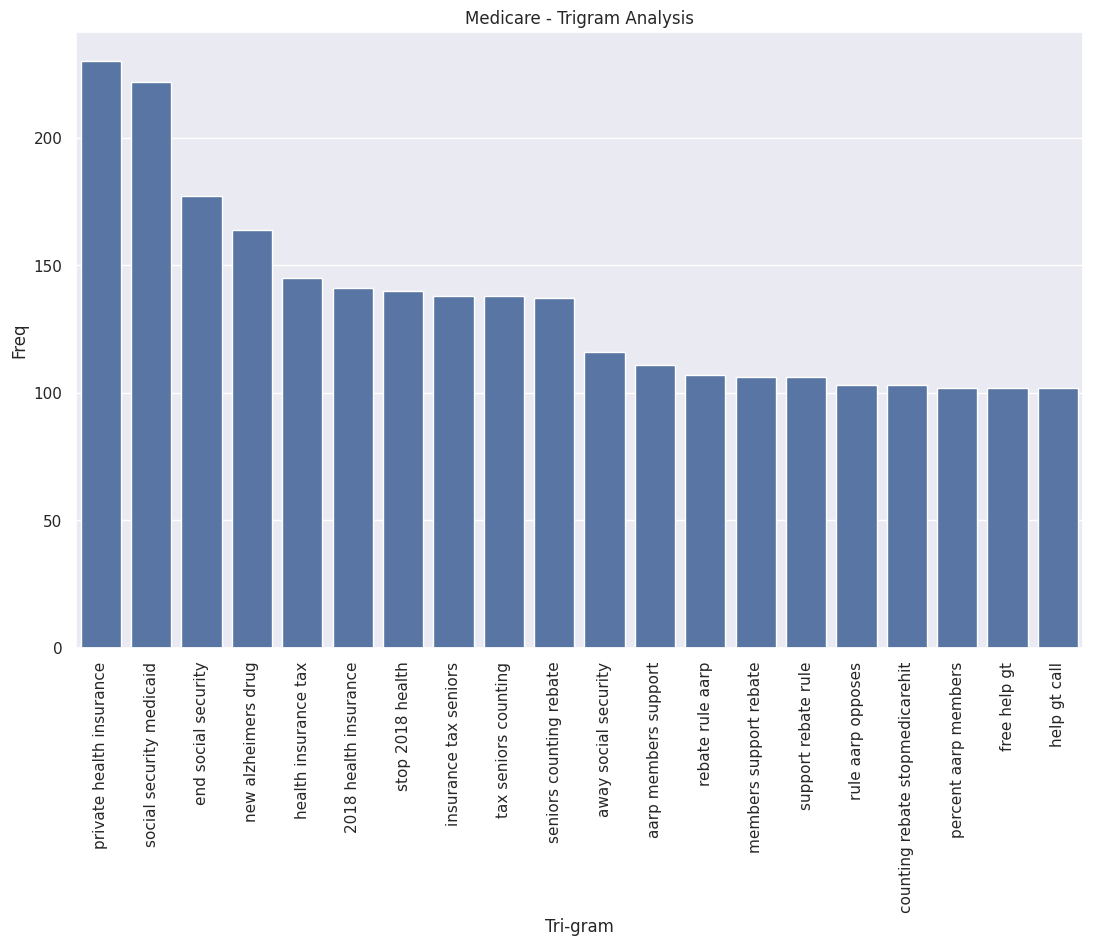

In [ ]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Medicare - Trigram Analysis')
plt.show()

### Insights:

The trigram 'private health insurance' refers to tweets of comparison between private health insurance and Medicare (federal). This might indicate that people are frequently comparing private health insurance services as to those of Medicare. Customers are also concerned about Health Insurance Regulations 2018, showing 'stop 2018 health' as a popular phrase. It can be derived that the rebate phrases are regarding this legislation. Customer might be sharing their opposition against something involved in this regulation.

## Temporal Analysis

Now let's attempt to explore temporal patterns.

In [ ]:
# Group the twitter dataset based on the date field and get the count per each day.
df_date_wise = df.groupby(['date'])['tweet'].count().reset_index(name='tweet_count_medicare').set_index('date')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_date_wise.sort_values(by='tweet_count_medicare',ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_count_medicare
date,
2022-04-06,4492
2022-04-07,3341
2022-04-10,3004
2022-04-08,2839
2022-04-09,2287
...,...
2017-11-12,1
2017-11-14,1
2020-06-26,1


In [ ]:
df_date_wise.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_count_medicare
date,
2022-04-07,3341
2022-04-08,2839
2022-04-09,2287
2022-04-10,3004
2022-04-11,375


Graph of Temporal Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


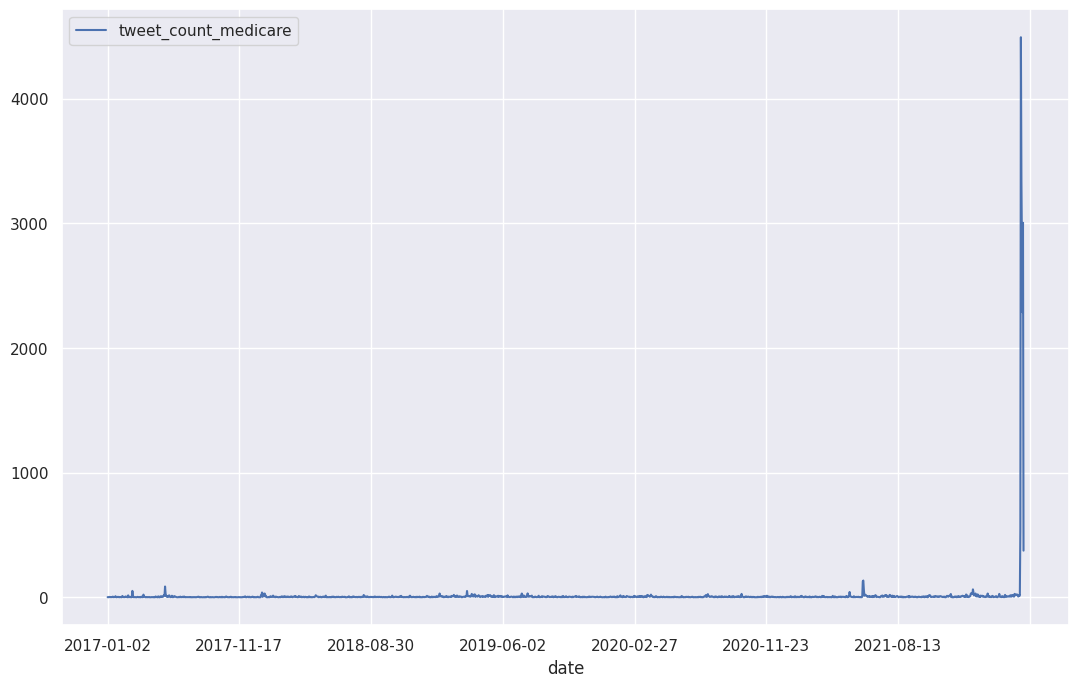

In [ ]:
ax = df_date_wise.plot()
plt.savefig('temporal_analysis_v2.png', dpi=800)

**Insights:**

Temporal Analysis reveals a consistent trend in tweet volume from 2017 to 2022, with a notable surge towards the end of 2021. This increase coincides with significant changes to the Medicare Benefits Schedule (MBS), particularly the indexation of various services and the implementation of recommendations from the clinician-led MBS Review Taskforce. The heightened engagement on Twitter during this period suggests an increased interest and awareness among customers regarding MBS updates and policy changes.

Output image is saved in files tab

In [ ]:
#To be used for presentation
'''
# this is a helper code if you have 3 or more dataframes to compare with.
df_ABC_date_wise =df_optus_date_wise.copy()
df_ABC_date_wise['tweet_count_ABV'] = df_ABC_date_wise['tweet_count_optus'] + 20
del df_ABC_date_wise['tweet_count_optus']

ax = df_telstra_date_wise.plot()
df_optus_date_wise.plot(ax=ax)
df_ABC_date_wise.plot(ax=ax)
plt.savefig('temporal_analysis_v3.png', dpi=800)
'''

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\n# this is a helper code if you have 3 or more dataframes to compare with.\ndf_ABC_date_wise =df_optus_date_wise.copy()\ndf_ABC_date_wise['tweet_count_ABV'] = df_ABC_date_wise['tweet_count_optus'] + 20\ndel df_ABC_date_wise['tweet_count_optus']\n\nax = df_telstra_date_wise.plot()\ndf_optus_date_wise.plot(ax=ax)\ndf_ABC_date_wise.plot(ax=ax)\nplt.savefig('temporal_analysis_v3.png', dpi=800)\n"

## Sentiment Analysis

Analyse sentiments for each tweet, aggregate into the sentiment of particular day and derive a sentiment timeline.

In [ ]:
# Extract sentiments from the tweets (This should take some time because we run this to the entire dataset.)
df_tweet_processed = df.copy()
df_tweet_processed.replace('', np.nan, inplace=True)
df_tweet_processed['tweet'] = df_tweet_processed['tweet'].astype(str)
df_tweet_processed['sentiment'] = df_tweet_processed['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display first 50 tweets with respective sentiment value (0 = neutral, positve value = positve sentiment, negative vale = negative sentiment)
df_tweet_processed[['tweet', 'sentiment']].head(50)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet,sentiment
0,era un boludou espaa tiene salud pblica inglat...,0.000000
1,telehealth ads still radio auspol election cal...,0.000000
2,bureaucracy nswhealth improve nsw rural health...,0.045455
3,dont like sound american health system protect...,0.200000
4,family member come issue today must changed au...,0.000000
5,claire yes govt determine rate services lets c...,0.250000
6,albo supported pliberseks disgusting 2019 ausv...,-0.500000
7,late news sydneythere new auspol govt taxpayer...,-0.081818
8,hasnt many countries australia,0.500000
9,answers auspol qt say genetic screening funded...,0.007143


Aggregate the sentiment value (using mean)

In [ ]:
df_tweet_processed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,time,tweet,tweet_stemmed,tweet_lemmatized,sentiment
0,2022-04-10,12:03:03,era un boludou espaa tiene salud pblica inglat...,era un bolud espaa tien salud pblica inglaterr...,era un boludou espaa tiene salud pblica inglat...,0.000000
1,2022-04-10,04:40:33,telehealth ads still radio auspol election cal...,telehealth ad still radio auspol elect call st...,telehealth ad still radio auspol election call...,0.000000
2,2022-04-09,06:00:49,bureaucracy nswhealth improve nsw rural health...,bureaucraci nswhealth improv nsw rural health ...,bureaucracy nswhealth improve nsw rural health...,0.045455
3,2022-04-08,23:56:21,dont like sound american health system protect...,dont like sound american health system protect...,dont like sound american health system protect...,0.200000
4,2022-04-08,00:22:35,family member come issue today must changed au...,famili member come issu today must chang austr...,family member come issue today must changed au...,0.000000
...,...,...,...,...,...,...
38106,2022-04-05,22:25:41,forgot inform mom got antibody test 62 fed bcb...,forgot inform mom got antibodi test 62 fed bcb...,forgot inform mom got antibody test 62 fed bcb...,0.000000
38107,2022-04-05,22:25:37,love god recant hypothetical veto offer full t...,love god recant hypothet veto medicar offer fu...,love god recant hypothetical veto medicare off...,0.283333
38108,2022-04-05,22:25:35,house bill called improved,hous bill call improv medicar,house bill called improved medicare,0.000000
38109,2022-04-05,22:25:29,also tuition free community colleges,also medicar tuition free commun colleg,also medicare tuition free community college,0.400000


In [ ]:
df_tweet_processed.groupby(['date'])['sentiment'].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date
2017-01-02    0.000000
2017-01-03    0.000000
2017-01-04   -0.200000
2017-01-05    0.025000
2017-01-06    0.425000
                ...   
2022-04-07    0.056618
2022-04-08    0.061662
2022-04-09    0.050209
2022-04-10    0.039710
2022-04-11    0.024634
Name: sentiment, Length: 1739, dtype: float64

Plotting the sentiment over time.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


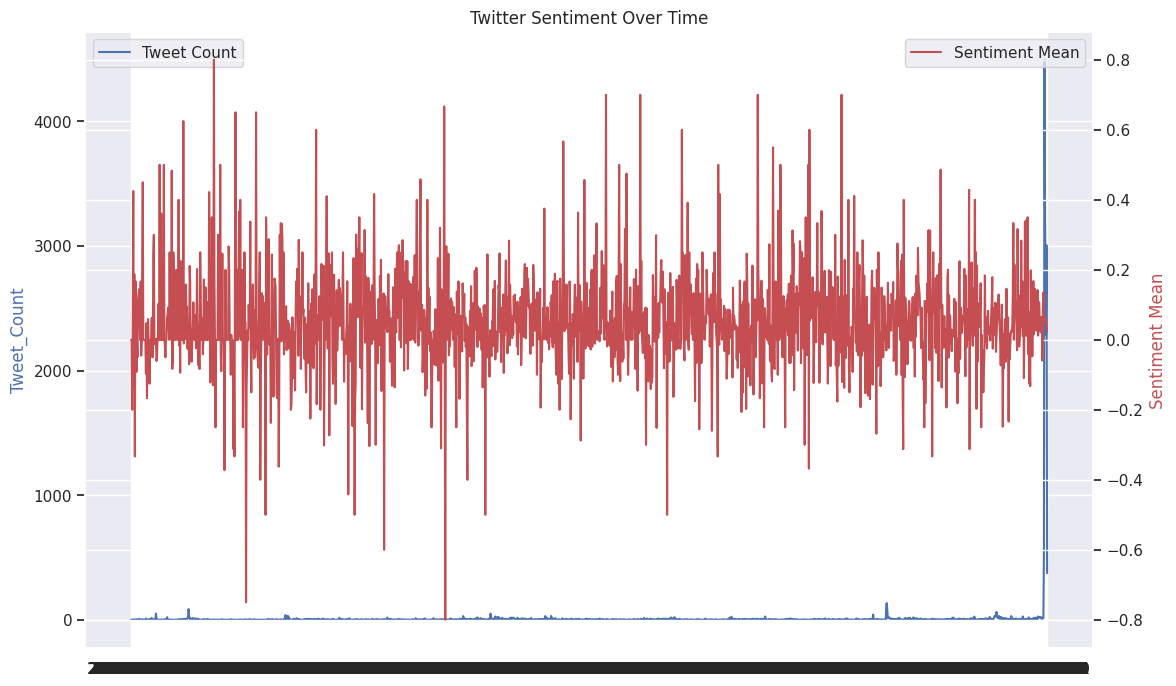

In [ ]:
# Plot twitter sentimet timeline
fig, ax1 = plt.subplots()

df_date_wise_processed = df_tweet_processed.groupby(['date'])['sentiment'].mean().reset_index(name='sentiment_mean').set_index('date')

# Plot the sentiment data on the first y-axis
ax1.plot(df_date_wise.index, df_date_wise['tweet_count_medicare'], label='Tweet Count', color='b')
ax1.set_ylabel('Tweet_Count', color='b')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the sentiment mean data on the second y-axis
ax2.plot(df_date_wise_processed.index, df_date_wise_processed['sentiment_mean'], label='Sentiment Mean', color='r')
ax2.set_ylabel('Sentiment Mean', color='r')

# Set labels and title
plt.xlabel('Month')
plt.title('Twitter Sentiment Over Time')

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot
plt.savefig('temporal_sentiment_v2.png', dpi=800)

# Show the plot (optional)
plt.show()

**Insights:**

As we can see from the sentiment over time plot, overall, there is a positive sentiment in most instances, indicating that most of the customers are satisfied using Medicare as their health insurance provider. The negative peaks occur due to customers feedback throughout the year, though they seem to be the highest towards the end of the year. The graph indicates that customers are mostly satisfied with using Medicare insurance as their health care provider.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


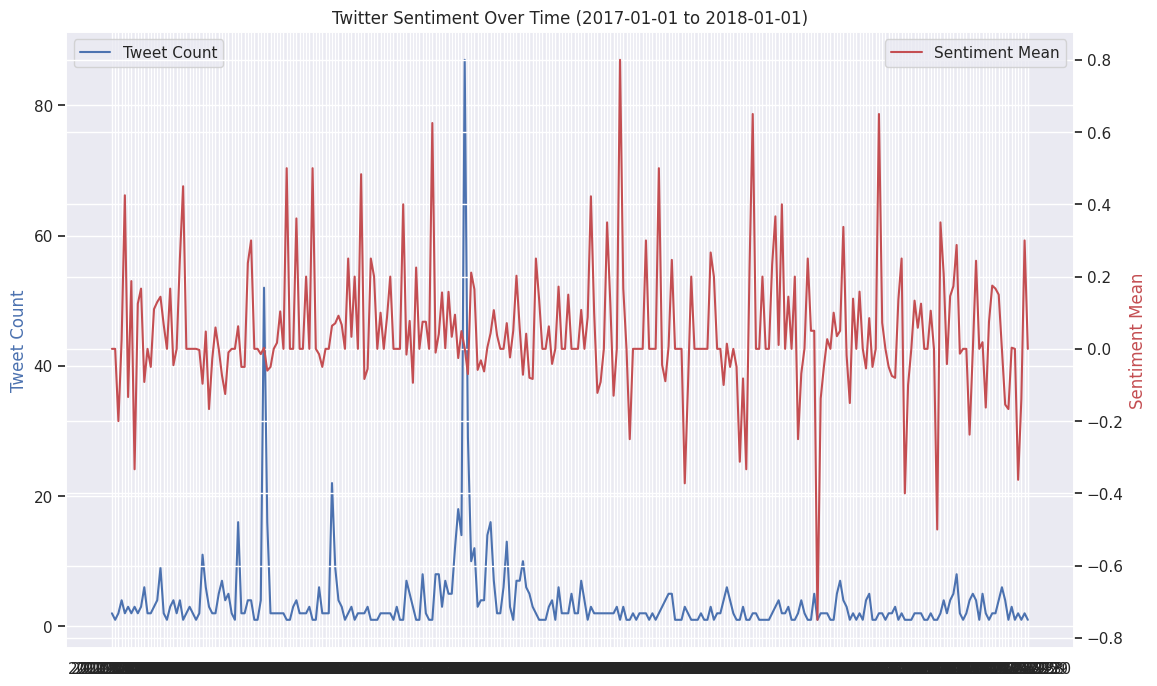

In [ ]:
# Assuming you already have df_date_wise with datetime index
start_date = '2017-01-01'
end_date = '2018-01-01'

# Filter data for the specified date range
filtered_df = df_date_wise.loc[start_date:end_date]

# Create the plot
fig, ax1 = plt.subplots()

# Plot tweet count on the first y-axis
ax1.plot(filtered_df.index, filtered_df['tweet_count_medicare'], label='Tweet Count', color='b')
ax1.set_ylabel('Tweet Count', color='b')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot sentiment mean on the second y-axis
ax2.plot(filtered_df.index, df_date_wise_processed.loc[start_date:end_date, 'sentiment_mean'], label='Sentiment Mean', color='r')
ax2.set_ylabel('Sentiment Mean', color='r')

# Set labels and title
plt.xlabel('Month')
plt.title('Twitter Sentiment Over Time (2017-01-01 to 2018-01-01)')

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot
plt.savefig('temporal_sentiment_v2.png', dpi=800)

# Show the plot (optional)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


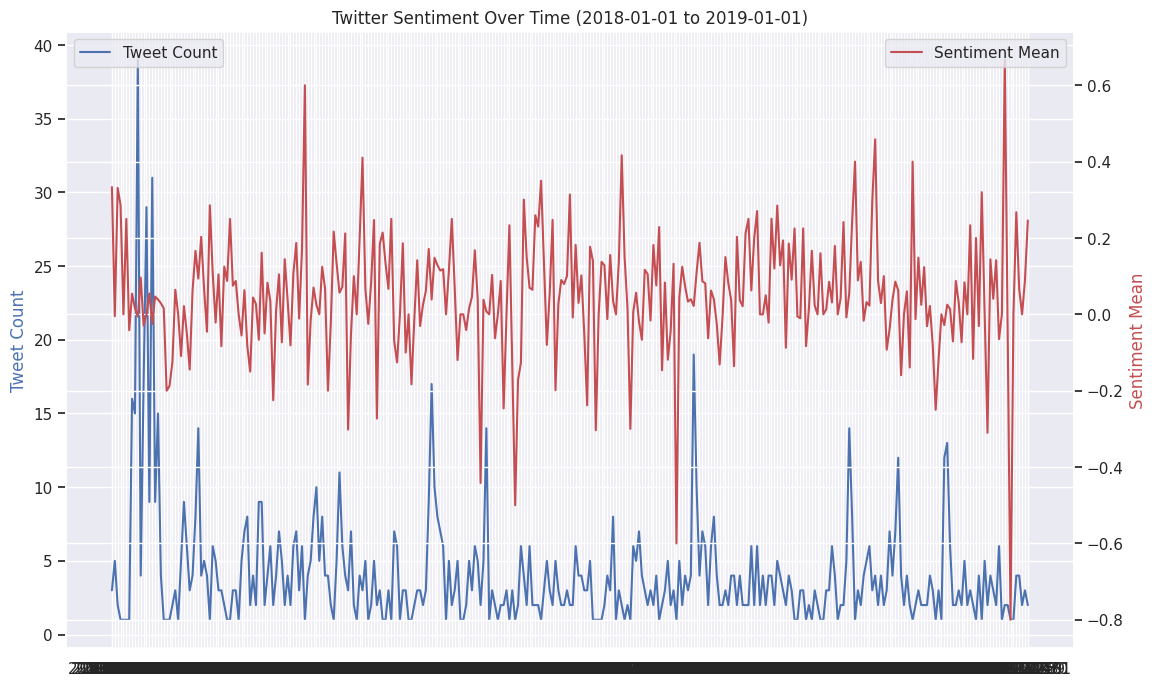

In [ ]:
# Assuming you already have df_date_wise with datetime index
start_date = '2018-01-01'
end_date = '2019-01-01'

# Filter data for the specified date range
filtered_df = df_date_wise.loc[start_date:end_date]

# Create the plot
fig, ax1 = plt.subplots()

# Plot tweet count on the first y-axis
ax1.plot(filtered_df.index, filtered_df['tweet_count_medicare'], label='Tweet Count', color='b')
ax1.set_ylabel('Tweet Count', color='b')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot sentiment mean on the second y-axis
ax2.plot(filtered_df.index, df_date_wise_processed.loc[start_date:end_date, 'sentiment_mean'], label='Sentiment Mean', color='r')
ax2.set_ylabel('Sentiment Mean', color='r')

# Set labels and title
plt.xlabel('Month')
plt.title('Twitter Sentiment Over Time (2018-01-01 to 2019-01-01)')

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot
plt.savefig('temporal_sentiment_v2.png', dpi=800)

# Show the plot (optional)
plt.show()

**Insights:**   
By analysing the sentiment overtime for 2017 - 2018 & 2018 - 2019, we can see that there are sharp peaks in the number of tweets. However, there is a trend of high negative sentiment at the end of the year. Moreover, the number of negative tweets has been higher in 2018, indicating customers perspective on Health Insurance Regulations 2018.

## Topic Modeling

We will now conduct a topic modeling the twitter dataset here.  
It is possible to conduct topic modeling using single words, bigrams, trigrams or n-grams.  
Topic modelling is a natural language analytics technique use to uncover the main themes or topics present in a collection of documents.
It's a form of unsupervised machine learning that aims to discover underlying patterns in textdata without any predefined labels or categories.
We will be using a topic modeling algorithm named - LDA (Latent Dirichlet Allocation) for this task.

In [ ]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we will create the text corpus.  


In [ ]:
# Convert the tweets as the text corpus.
corpus = list(df_tweet_processed['tweet'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['era un boludou espaa tiene salud pblica inglaterra italia tiene entre los 10 mejores del mundo alemania tiene un seguro tiempo australia tiene mixta francia tiene salud pblica canad sistema mixto todos pero todos vienen mejor que nosotros',
 'telehealth ads still radio auspol election called stop ausvotes medicareaustralia',
 'bureaucracy nswhealth improve nsw rural health rumours new tweedvalleyhospital not public ophthalmology services like cataract surgery maybe rhd guarantee nswpol auspol medicareaustralia',
 'dont like sound american health system protect australia auspol',
 'family member come issue today must changed australians without regular gp locked bulkbilled telehealth consults australia guardian']

In [ ]:
# Tokenization
tweet_texts = [[word for word in str(document).split()] for document in corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tweet_texts[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['era',
  'un',
  'boludou',
  'espaa',
  'tiene',
  'salud',
  'pblica',
  'inglaterra',
  'italia',
  'tiene',
  'entre',
  'los',
  '10',
  'mejores',
  'del',
  'mundo',
  'alemania',
  'tiene',
  'un',
  'seguro',
  'tiempo',
  'australia',
  'tiene',
  'mixta',
  'francia',
  'tiene',
  'salud',
  'pblica',
  'canad',
  'sistema',
  'mixto',
  'todos',
  'pero',
  'todos',
  'vienen',
  'mejor',
  'que',
  'nosotros'],
 ['telehealth',
  'ads',
  'still',
  'radio',
  'auspol',
  'election',
  'called',
  'stop',
  'ausvotes',
  'medicareaustralia'],
 ['bureaucracy',
  'nswhealth',
  'improve',
  'nsw',
  'rural',
  'health',
  'rumours',
  'new',
  'tweedvalleyhospital',
  'not',
  'public',
  'ophthalmology',
  'services',
  'like',
  'cataract',
  'surgery',
  'maybe',
  'rhd',
  'guarantee',
  'nswpol',
  'auspol',
  'medicareaustralia'],
 ['dont',
  'like',
  'sound',
  'american',
  'health',
  'system',
  'protect',
  'australia',
  'auspol'],
 ['family',
  'member',
  'co

In [ ]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(tweet_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'tweet.dict'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


When creating the dictionary, each tweet (document) is alphabetically sorted before composing the dictionary.

In [ ]:
print(tweet_texts[0])
print('alphabetically sorted', sorted(tweet_texts[0]))

['era', 'un', 'boludou', 'espaa', 'tiene', 'salud', 'pblica', 'inglaterra', 'italia', 'tiene', 'entre', 'los', '10', 'mejores', 'del', 'mundo', 'alemania', 'tiene', 'un', 'seguro', 'tiempo', 'australia', 'tiene', 'mixta', 'francia', 'tiene', 'salud', 'pblica', 'canad', 'sistema', 'mixto', 'todos', 'pero', 'todos', 'vienen', 'mejor', 'que', 'nosotros']
alphabetically sorted ['10', 'alemania', 'australia', 'boludou', 'canad', 'del', 'entre', 'era', 'espaa', 'francia', 'inglaterra', 'italia', 'los', 'mejor', 'mejores', 'mixta', 'mixto', 'mundo', 'nosotros', 'pblica', 'pblica', 'pero', 'que', 'salud', 'salud', 'seguro', 'sistema', 'tiempo', 'tiene', 'tiene', 'tiene', 'tiene', 'tiene', 'todos', 'todos', 'un', 'un', 'vienen']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(tweet_texts[1])
print('alphabetically sorted', sorted(tweet_texts[1]))

['telehealth', 'ads', 'still', 'radio', 'auspol', 'election', 'called', 'stop', 'ausvotes', 'medicareaustralia']
alphabetically sorted ['ads', 'auspol', 'ausvotes', 'called', 'election', 'medicareaustralia', 'radio', 'still', 'stop', 'telehealth']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'10': 0, 'alemania': 1, 'australia': 2, 'boludou': 3, 'canad': 4, 'del': 5, 'entre': 6, 'era': 7, 'espaa': 8, 'francia': 9, 'inglaterra': 10, 'italia': 11, 'los': 12, 'mejor': 13, 'mejores': 14, 'mixta': 15, 'mixto': 16, 'mundo': 17, 'nosotros': 18, 'pblica': 19, 'pero': 20, 'que': 21, 'salud': 22, 'seguro': 23, 'sistema': 24, 'tiempo': 25, 'tiene': 26, 'todos': 27, 'un': 28, 'vienen': 29, 'ads': 30, 'auspol': 31, 'ausvotes': 32, 'called': 33, 'election': 34, 'medicareaustralia': 35, 'radio': 36, 'still': 37, 'stop': 38, 'telehealth': 39, 'bureaucracy': 40, 'cataract': 41, 'guarantee': 42, 'health': 43, 'improve': 44, 'like': 45, 'maybe': 46, 'new': 47, 'not': 48, 'nsw': 49, 'nswhealth': 50, 'nswpol': 51, 'ophthalmology': 52, 'public': 53, 'rhd': 54, 'rumours': 55, 'rural': 56, 'services': 57, 'surgery': 58, 'tweedvalleyhospital': 59, 'american': 60, 'dont': 61, 'protect': 62, 'sound': 63, 'system': 64, 'australians': 65, 'bulkbilled': 66, 'changed': 67, 'come': 68, 'consults': 69, 'f

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in tweet_texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tweet_id = 0
print(tweet_texts[tweet_id]) # each tweet converted to tokens
print(dictionary.doc2bow(tweet_texts[tweet_id])) # each token is represented as a id from a dictionary

['era', 'un', 'boludou', 'espaa', 'tiene', 'salud', 'pblica', 'inglaterra', 'italia', 'tiene', 'entre', 'los', '10', 'mejores', 'del', 'mundo', 'alemania', 'tiene', 'un', 'seguro', 'tiempo', 'australia', 'tiene', 'mixta', 'francia', 'tiene', 'salud', 'pblica', 'canad', 'sistema', 'mixto', 'todos', 'pero', 'todos', 'vienen', 'mejor', 'que', 'nosotros']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 5), (27, 2), (28, 2), (29, 1)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Generate the topic model

In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We need to define how many topics we capture through LDA. We will set 40 topics to capture.

In [ ]:
total_topics = 40

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below code will build the LDA topic model.   
We have everything required to train the LDA model. In addition to the corpus and dictionary, we will need to provide the number of topics as well (defined above).



In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.  
You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.





In [ ]:
# Print the Keyword in the 40 topics
lda.show_topics(total_topics, num_words=6)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.082*"vote" + 0.079*"party" + 0.043*"que" + 0.043*"power" + 0.037*"kill" + 0.027*"u"'),
 (1,
  '0.056*"65" + 0.030*"tweet" + 0.030*"tell" + 0.020*"especially" + 0.018*"hey" + 0.018*"name"'),
 (2,
  '0.068*"americans" + 0.029*"lower" + 0.025*"raise" + 0.019*"need" + 0.018*"end" + 0.017*"control"'),
 (3,
  '0.040*"literally" + 0.037*"million" + 0.023*"means" + 0.020*"loan" + 0.019*"cost" + 0.018*"people"'),
 (4,
  '0.068*"home" + 0.030*"youd" + 0.029*"en" + 0.029*"citizens" + 0.028*"course" + 0.026*"first"'),
 (5,
  '0.056*"free" + 0.039*"sign" + 0.034*"healthcare" + 0.031*"vision" + 0.028*"news" + 0.028*"call"'),
 (6,
  '0.155*"republicans" + 0.046*"age" + 0.028*"trying" + 0.023*"socialist" + 0.023*"tried" + 0.023*"probably"'),
 (7,
  '0.048*"right" + 0.032*"not" + 0.023*"cuts" + 0.020*"afford" + 0.020*"old" + 0.017*"shit"'),
 (8,
  '0.066*"ss" + 0.034*"youre" + 0.032*"student" + 0.031*"wants" + 0.030*"debt" + 0.030*"education"'),
 (9,
  '0.049*"ban" + 0.027*"talking" + 0.025*"

**Insights:**

Using topic 27 as an example, it is a topic represented as '0.053*"healthcare" + 0.040*"system" + 0.035*"public" + 0.033*"rid" + 0.027*"save" + 0.024*"money"
  
It means the top 6 keywords that contribute to this topic are: healthcare, system, public, rid, save, money and the weight of ‘healthcare’ on topic 27 is 0.053.  
  
The weights reflect how important a keyword is to that topic.  

Looking at these keywords, we can guess that the topic might be related to people tweeting about getting rid of the public healthcare system to save money for the government and themselves or due to rebate freezes they have to pay a larger out of poclet cost and dont find medicare useful

Likewise, we can go through the remaining keyword subsets and infer each topic.  







### Interactive topic analyzer

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      1.903470 -1.790301       1        1  30.182062
17     1.647933 -2.901215       2        1   3.624948
34     1.267817 -3.604052       3        1   2.797901
22     1.641867 -3.227750       4        1   2.760435
15     1.907023 -3.415444       5        1   2.449250
37     1.066231 -3.240468       6        1   2.129036
3      1.227859 -3.357559       7        1   2.006305
32     1.214554 -3.398011       8        1   1.828147
5      0.572999 -2.511295       9        1   1.657648
23     1.524880 -2.823620      10        1   1.651492
11     1.616082 -2.194130      11        1   1.641076
19     1.136156 -3.291216      12        1   1.631192
33     2.208174 -3.086012      13        1   1.630018
24     1.628631 -4.008334      14        1   1.630018
30     1.792530 -2.168395      15        1   1.630018
29     2.266641 -2.405523      16        1   1.630018
35     1.660370 -2.291310      17        1   1.630018
28     2.044158 -3.670722      18        1   1.630018
36     1.589154 -3.762661      19        1   1.630018
27     1.727953 -3.709385      20        1   1.630018
26     1.189507 -3.991601      21        1   1.630018
25     0.980339 -3.418212      22        1   1.630018
38     1.126215 -3.363333      23        1   1.630018
31     0.459611 -3.970936      24        1   1.630018
20     1.403113 -3.001490      25        1   1.630018
21     0.775066 -2.774302      26        1   1.630018
1      1.093599 -3.025206      27        1   1.630018
18     0.893988 -3.694756      28        1   1.630018
16     1.361726 -4.623797      29        1   1.630018
14     2.053259 -4.080306      30        1   1.630018
13     0.971934 -2.070238      31        1   1.630018
12     0.769777 -3.972827      32        1   1.630018
10     1.274830 -4.206376      33        1   1.630018
9      0.451699 -3.153553      34        1   1.630018
8      0.655647 -3.464464      35        1   1.630018
7      1.255579 -3.498488      36        1   1.630018
6      2.148120 -2.822181      37        1   1.630018
4      1.459010 -2.426572      38        1   1.630018
2      0.868677 -3.435626      39        1   1.630018
39     0.385688 -3.199226      40        1   1.630018, topic_info=       Term        Freq       Total Category  logprob  loglift
209   party  497.000000  497.000000  Default  30.0000  30.0000
181    vote  531.000000  531.000000  Default  29.0000  29.0000
21      que  272.000000  272.000000  Default  28.0000  28.0000
2736  power  271.000000  271.000000  Default  27.0000  27.0000
5532   kill  233.000000  233.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
248    free    3.643363   44.203701  Topic40  -4.5374   1.6207
230    next    2.611119    9.815547  Topic40  -4.8705   2.7924
566    time    3.114544   28.165554  Topic40  -4.6942   1.9146
993    know    2.917105   34.260888  Topic40  -4.7597   1.6532
707   cover    2.820274   38.112822  Topic40  -4.7934   1.5129

[2087 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2198      6  0.935738      0
112       2  0.044257      1
112       3  0.044257      1
112       4  0.132772      1
112       5  0.044257      1
...     ...       ...    ...
1784     29  0.199984  youve
1784     37  0.599951  youve
2956     34  1.020445    yrs
2027     19  1.472134    yup
1213     34  0.924607   zero

[3781 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 18, 35, 23, 16, 38, 4, 33, 6, 24, 12, 20, 34, 25, 31, 30, 36, 29, 37, 28, 27, 26, 39, 32, 21, 22, 2, 19, 17, 15, 14, 13, 11, 10, 9, 8, 7, 5, 3, 40])

Using the relevance slider on interactive topic modelling, we can infer on the highly frequent relevant terms in each topic and their estimated term frequency in each topic.

## References

1.   [LDA Topic Modeling](https://youtu.be/3mHy4OSyRf0)
2.   [Topic Modelling in Python - Tutorial](https://ourcodingclub.github.io/2018/12/10/topic-modelling-python.html)

# Sarcasm Detection

Here, using a model from huggingface, we have attempted to detect sarcasm on tweets on the entire dataset. Value of 1 indicates that it is identified as sarcastic and 0 indicates that it is not sarcastic. The confidence column indicates the confidence level of sarcasm detection. We have only produced an output of 20 tweets since our dataset includes thousands of tweets and it would take siginificnt time to load results for all the tweets.

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import string


def preprocess_data(text: str) -> str:
   return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()


MODEL_PATH = "helinivan/english-sarcasm-detector"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

sarcastic_predictions = []
confidence_values = []

for tweet_text in df_original['tweet'][:20]:
    if isinstance(tweet_text, str):
        preprocessed_tweet = preprocess_data(tweet_text)
        tokenized_text = tokenizer([preprocessed_tweet], padding=True, truncation=True, max_length=256, return_tensors="pt")
        output = model(**tokenized_text)
        probs = output.logits.softmax(dim=-1).tolist()[0]
        confidence = max(probs)
        prediction = probs.index(confidence)
        sarcastic_predictions.append(prediction)
        confidence_values.append(confidence)
    else:
        continue

# Assign the collected values to DataFrame columns
df_original['is_sarcastic']=''
df_original['confidence']=''
df_original['is_sarcastic'][:20]= sarcastic_predictions
df_original['confidence'][:20]= confidence_values

df_original.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

,id,created_at,date,time,username,name,tweet,language,hashtags,is_sarcastic,confidence
0,1513125404063645698,2022-04-10 12:03:03+00:00,2022-04-10,12:03:03,estebanlaplata,Luislaplata,@luisanibalmend2 @barbraguinsky @LaRubiaOk Era...,es,[],0,0.718884
1,1513014045082746883,2022-04-10 04:40:33+00:00,2022-04-10,04:40:33,muzzpol,Muzzpol,The #telehealth ads are STILL on the radio aft...,en,"['telehealth', 'auspol', 'ausvotes', 'medicare...",0,0.994756
2,1512671857803104257,2022-04-09 06:00:49+00:00,2022-04-09,06:00:49,muzzpol,Muzzpol,Will more bureaucracy in #NSWHealth improve #N...,en,"['nswhealth', 'nsw', 'rural', 'tweedvalleyhosp...",0,0.983999
3,1512580134314049536,2022-04-08 23:56:21+00:00,2022-04-08,23:56:21,pnslipper,Peter Slipper,I don't like the sound of the American Health ...,en,"['medicare', 'auspol']",0,0.99273
4,1512224349561925634,2022-04-08 00:22:35+00:00,2022-04-08,00:22:35,aparachick,aparachick,Just had a family member come up against this ...,en,[],0,0.992254
5,1511841201024118786,2022-04-06 23:00:05+00:00,2022-04-06,23:00:05,felixrandal,Felix Randal,@richardcalhoun @AllisonPearson @Fox_Claire Ye...,en,[],1,0.550028
6,1511614321779830787,2022-04-06 07:58:33+00:00,2022-04-06,07:58:33,muzzpol,Muzzpol,#Albo supported #Plibersek's disgusting 2019 #...,en,"['albo', 'plibersek', 'ausvotes', 'abortion', ...",1,0.789118
7,1510598561666265099,2022-04-03 12:42:17+00:00,2022-04-03,12:42:17,muzzpol,Muzzpol,"During the @9NewsAUS late news in #Sydney,ther...",en,"['sydney', 'auspol', 'taxpayer', 'advertising'...",0,0.794559
8,1510571572569919494,2022-04-03 10:55:02+00:00,2022-04-03,10:55:02,mikesma20797052,Mike Smart,@AvonandsomerRob 🥴🤣🤣🤣🤣 hasn't been to many cou...,en,[],0,0.616242
9,1509119505426837510,2022-03-30 10:45:02+00:00,2022-03-30,10:45:02,muzzpol,Muzzpol,"Answers in #Auspol #QT say ""#genetic screening...",en,"['auspol', 'qt', 'genetic', 'budget22', 'sma',...",0,0.619474


**Insights**

The analysis found minimal instances of sarcasm within tweet sentiment related to Medicare. This could be attributed to the serious nature of topics discussed, such as regulatory changes and health coverage, which may not lend themselves well to sarcasm. Additionally, relying solely on NLP models for sarcasm detection may pose challenges due to the nuanced and context-dependent nature of sarcasm.